In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

^C


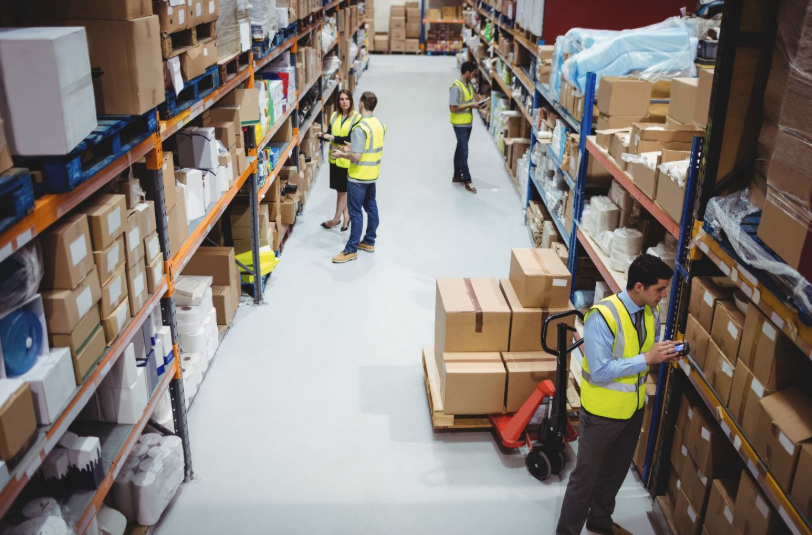
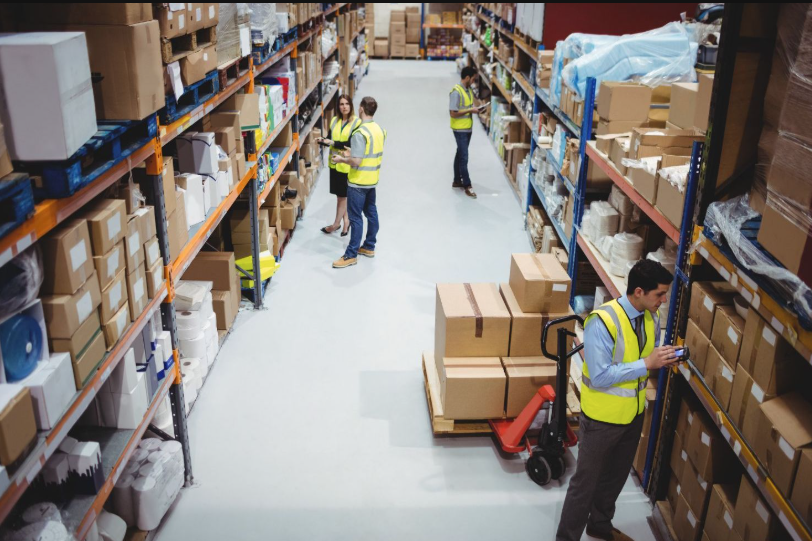



# 1. Introduction - Evaluating Warehouse Picking Methods with ANOVA & SPC
In warehouse operations, picking methods directly affect efficiency.  
We will compare Discrete, Batch, and Wave picking to test:
1. Do the methods differ significantly in mean picking times? (ANOVA)  
2. Are they stable and in control over time? (SPC Charts)  

---

# 2. Data Setup
We will simulate picking times:
- Discrete: mean = 305s, std = 20  
- Batch: mean = 290s, std = 35  
- Wave: mean = 260s, std = 70  
100 observations per method.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Reproducibility
np.random.seed(42)

# Simulated dataset
n = 100
data = pd.DataFrame({
    "Method": (["Discrete"]*n + ["Batch"]*n + ["Wave"]*n),
    "Time": (np.random.normal(305, 20, n).tolist() +
             np.random.normal(290, 35, n).tolist() +
             np.random.normal(260, 70, n).tolist())
})

data.head()


,Method,Time
0,Discrete,314.934283
1,Discrete,302.234714
2,Discrete,317.953771
3,Discrete,335.460597
4,Discrete,300.316933


# 3. Exploratory Data Analysis (EDA)
- Distribution of times by method  
- Boxplots to visualize spread and central tendency
- Density plot to show distribution overlap.


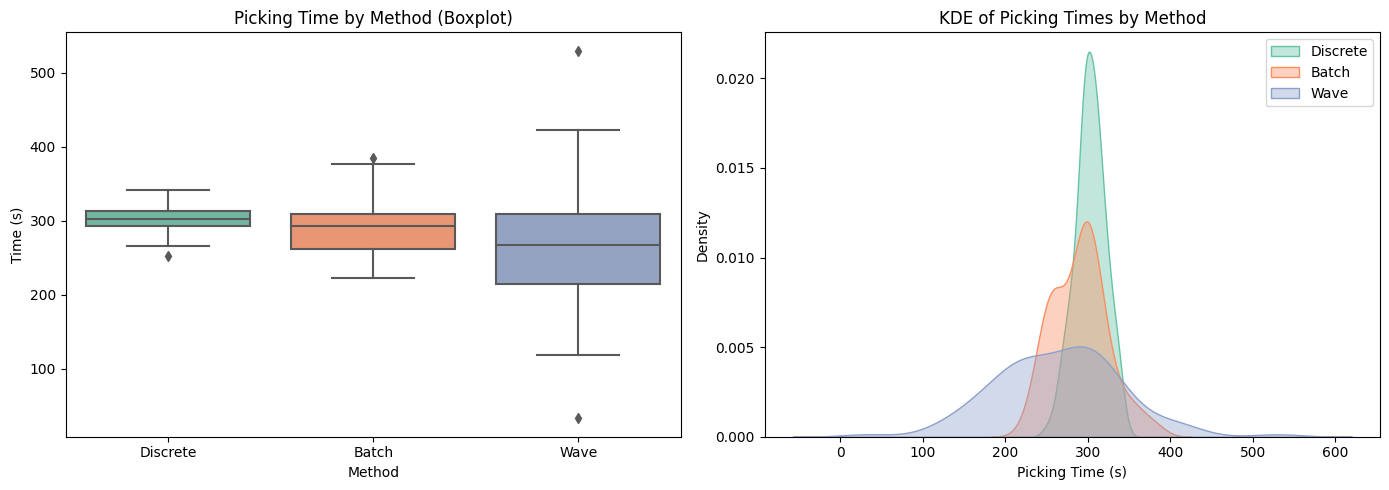

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent color palette
palette = {"Discrete": "#66c2a5", "Batch": "#fc8d62", "Wave": "#8da0cb"}

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Boxplot ---
sns.boxplot(x="Method", y="Time", data=data, palette=palette, ax=axes[0])
axes[0].set_title("Picking Time by Method (Boxplot)")
axes[0].set_ylabel("Time (s)")

# --- KDE Plot ---
for method in data["Method"].unique():
    sns.kdeplot(
        data=data[data["Method"]==method],
        x="Time",
        fill=True, alpha=0.4,
        label=method, color=palette[method],
        ax=axes[1]
    )

axes[1].set_title("KDE of Picking Times by Method")
axes[1].set_xlabel("Picking Time (s)")
axes[1].set_ylabel("Density")
axes[1].legend()

plt.tight_layout()
plt.show()




## 4. ANOVA Test (Analysis of Variance)

- Null hypothesis: μ_Discrete = μ_Batch = μ_Wave  
- Alternative hypothesis: At least one mean differs  

ANOVA tests whether the average picking times across the three methods are statistically equal.  
If the p-value is low, we reject the null and conclude that at least one method has a significantly different mean time.  


In [49]:
# One-way ANOVA
import warnings
warnings.filterwarnings('ignore')

model = ols('Time ~ Method', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
Method,76963.885758,2.0,16.023446,2.463487e-07
Residual,713275.831089,297.0,NaN,NaN


## 4.1 Understanding the ANOVA Table

The `anova_table` output shows the statistical results of a One-Way ANOVA test.  
It breaks down the variation in picking times into two parts:

| Column | Meaning |
|--------|----------|
| **sum_sq** | The **sum of squares** (amount of variation) explained by that source. |
| **df** | The **degrees of freedom** — how many independent pieces of information went into that estimate. |
| **F** | The **F-statistic** — ratio of variation *between groups* vs. *within groups*. A bigger F means stronger evidence that group means differ. |
| **PR(>F)** | The **p-value** — probability of seeing results this extreme if all group means were really equal (the null hypothesis). |

### How to read it
- **Method row** → shows how much variation in picking times is explained by the choice of method (Discrete, Batch, Wave).  
- **Residual row** → variation that’s just random noise within each method group.  

### Decision Rule
- Look at PR(>F) (the p-value for Method).  
- If p < 0.05 → reject the null hypothesis → conclude that *at least one picking method has a different mean time*.  
- If p ≥ 0.05 → fail to reject the null → conclude that differences are not statistically significant.




## 4.2 Tukey HSD Post-hoc Test

After ANOVA tells us that at least one group mean is different, we need to find out which groups differ.  
That’s what Tukey’s Honestly Significant Difference (HSD) test does.

### What the table shows:
- **group1 / group2** → The two methods being compared (e.g., Discrete vs. Batch).  
- **meandiff** → The difference in their mean picking times.  
- **p-adj** → The adjusted p-value (accounts for multiple comparisons).  
- **lower / upper** → The confidence interval for the mean difference.  
- **reject** → `True` if the difference is statistically significant at α = 0.05, `False` if not.  

In [50]:
# Tukey HSD post-hoc test
tukey = pairwise_tukeyhsd(endog=data["Time"], groups=data["Method"], alpha=0.05)
print(tukey)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
   Batch Discrete  12.1424 0.1878  -4.1826  28.4674  False
   Batch     Wave -26.2379 0.0005 -42.5629  -9.9129   True
Discrete     Wave -38.3803    0.0 -54.7053 -22.0553   True
----------------------------------------------------------


### How to read it:
- If **reject = True** → we have enough evidence to say the two methods have different mean times.  
- If **reject = False** → no significant difference between those two methods.  
- The sign of meandiff tells you *which way* the difference goes:  
  - Positive → group1 > group2  
  - Negative → group1 < group2  


# 5. SPC Charts (Statistical Process Control)

SPC charts monitor whether a process is stable or showing unusual variation.  
They use a center line (mean) and control limits (mean ± 3σ). Points outside the limits or unusual patterns signal instability.

For warehouse picking times, we use an Individuals (I) Chart since data is recorded one order at a time.

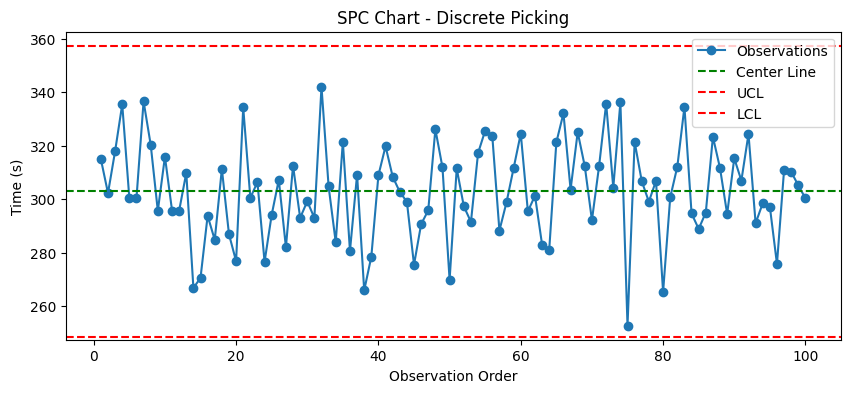

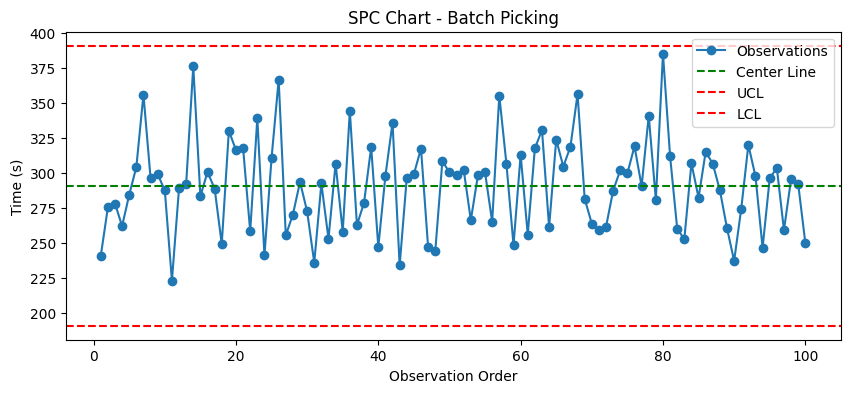

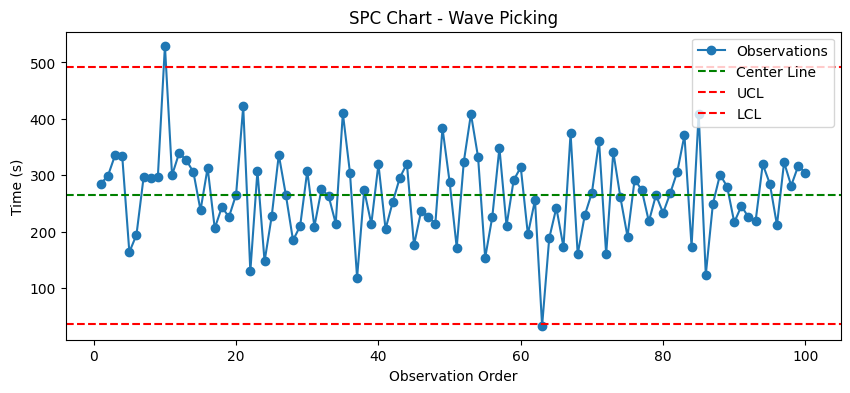

In [51]:
def spc_chart(method):
    sub = data[data["Method"] == method].reset_index(drop=True)
    sub["Obs"] = sub.index + 1
    mean = sub["Time"].mean()
    sigma = sub["Time"].std()
    UCL = mean + 3*sigma
    LCL = mean - 3*sigma

    plt.figure(figsize=(10,4))
    plt.plot(sub["Obs"], sub["Time"], marker="o", linestyle="-", label="Observations")
    plt.axhline(mean, color="green", linestyle="--", label="Center Line")
    plt.axhline(UCL, color="red", linestyle="--", label="UCL")
    plt.axhline(LCL, color="red", linestyle="--", label="LCL")
    plt.title(f"SPC Chart - {method} Picking")
    plt.xlabel("Observation Order")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

for m in data["Method"].unique():
    spc_chart(m)


#### Comparing All Methods Together

Now that we have examined each individual SPC chart, we can place all the methods on a single chart.  
This allows us to see the methods in proportion to one another, highlighting how their picking times overlap and differ when viewed side by side.  
Looking at them together provides context for both quickness and stability relative to the other methods.  


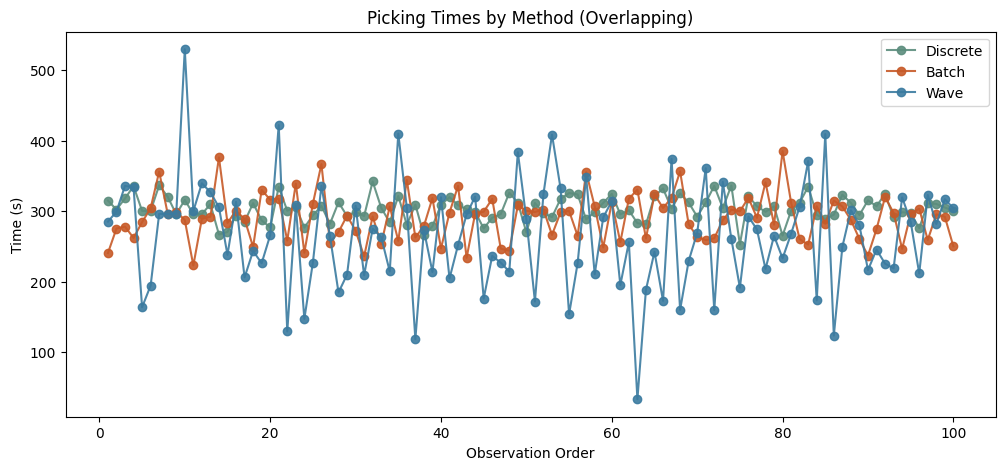

In [60]:
import matplotlib.pyplot as plt

colors = {
    "Discrete": "#5c8d7d",  # darker greenish-blue
    "Batch": "#c75a28",     # darker orange
    "Wave": "#3b7ba0"       # darker light blue
}

plt.figure(figsize=(12,5))

for m in data["Method"].unique():
    sub = data[data["Method"] == m].reset_index(drop=True)
    sub["Obs"] = sub.index + 1
    plt.plot(sub["Obs"], sub["Time"], marker="o", linestyle="-",
             label=m, color=colors[m], alpha=0.9)

plt.title("Picking Times by Method (Overlapping)")
plt.xlabel("Observation Order")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


## 5.1 Interpretation  
- Points within limits suggest stability.  
- Points outside limits or strong trends suggest instability.  
- Comparing methods: Discrete is the most stable but the slowest, batch picking has slightly less stable performance but quicker, and Wave is fast but less controlled.

Conclusion:  
SPC charts add to ANOVA by showing not only differences in average times but also which method is most consistent over time.

# 6. From Analysis to Decision

So far we have used: 
- ANOVA to test for differences in average picking times
- Tukey’s test to identify which pairs of methods differ
- SPC charts to evaluate the stability of each method over time.  
The next question is: how do we actually decide which method to adopt?  

The answer depends on priorities.  
If management values speed above all else, the method with the lowest average time may be chosen, even if it is less stable.  
If consistency and predictability are more important, a slightly slower but more stable method could be preferred.  
To formalize this trade-off, we can design a simple model where the user specifies how much weight to place on quickness versus stability, and the model recommends the most suitable picking method accordingly.  


## 6.1 Example (α = 0.6)

Alpha represents the balance between speed and stability.  
At alpha = 0.6, we give 60% weight to quickness and 40% to stability.  
This leans toward speed but still considers consistency.  

### Reading the table

| Column | Meaning |
|--------|---------|
| mu     | Mean picking time (lower = faster) |
| sigma  | Standard deviation (lower = more consistent) |
| ooc    | Out-of-control rate (lower = more stable) |
| mu_n   | Normalized mean time (scaled 0–1) |
| S      | Stability index (from sigma and ooc) |
| score  | Weighted value = 0.6·mu_n + 0.4·S (lower is better) |


In [63]:
# 1) Compute metrics per method
def spc_metrics(df):
    out = []
    for m, sub in df.groupby("Method"):
        t = sub["Time"].values
        mu = t.mean()
        sigma = t.std(ddof=1)
        ucl = mu + 3*sigma
        lcl = mu - 3*sigma
        ooc = ((t > ucl) | (t < lcl)).mean()  # fraction of out-of-control points
        out.append({"Method": m, "mu": mu, "sigma": sigma, "ooc": ooc})
    return pd.DataFrame(out)

met = spc_metrics(data)

# 2) Min–max normalize (lower is better)
def minmax(s):
    lo, hi = s.min(), s.max()
    return (s - lo) / (hi - lo) if hi > lo else 0

met["mu_n"]    = minmax(met["mu"])
met["sigma_n"] = minmax(met["sigma"])
met["ooc_n"]   = minmax(met["ooc"])

# 3) Stability index (equal weights on sigma and out-of-control rate)
beta_sigma, beta_ooc = 0.5, 0.5
met["S"] = beta_sigma*met["sigma_n"] + beta_ooc*met["ooc_n"]

# 4) User preference: alpha close to 1 favors speed, near 0 favors stability
alpha = 0.6  

met["score"] = alpha*met["mu_n"] + (1-alpha)*met["S"]
chosen = met.loc[met["score"].idxmin(), "Method"]

print("alpha =", alpha)
print("chosen method:", chosen)
display(met[["Method","mu","sigma","ooc","mu_n","S","score"]])


alpha = 0.6
chosen method: Wave


,Method,mu,sigma,ooc,mu_n,S,score
0,Batch,290.780661,33.378414,0.00,0.683629,0.131763,0.462883
1,Discrete,302.923070,18.163369,0.00,1.000000,0.000000,0.600000
2,Wave,264.542738,75.899802,0.02,0.000000,1.000000,0.400000


The method with the lowest score is chosen.  
At alpha = 0.6, Wave has the lowest score (0.400), so it is recommended.  


## 6.2 How the Recommendation Changes with Alpha

So far, we have looked at a single value of alpha (for example 0.6) to decide which picking method is preferred.  
But alpha can range anywhere between 0 (all stability) and 1 (all speed).  
As we change alpha, the balance between speed and stability shifts, and the recommended method may change as well.  

By plotting the recommendation as a function of alpha, we can see the regions where each method is best suited.  
This gives a clear, intuitive picture of how sensitive the decision is to management’s priorities:  
- On the left side (low alpha), stability-focused methods dominate.  
- On the right side (high alpha), the fastest method tends to win.  
- In the middle, trade-offs become more apparent.  

Such a graph turns the abstract idea of “preference weighting” into something visual and easy to interpret.  


,alpha,Batch,Discrete,Wave,Chosen
0,0.00,0.131763,0.00,1.00,Discrete
1,0.02,0.142800,0.02,0.98,Discrete
2,0.04,0.153838,0.04,0.96,Discrete
3,0.06,0.164875,0.06,0.94,Discrete
4,0.08,0.175912,0.08,0.92,Discrete


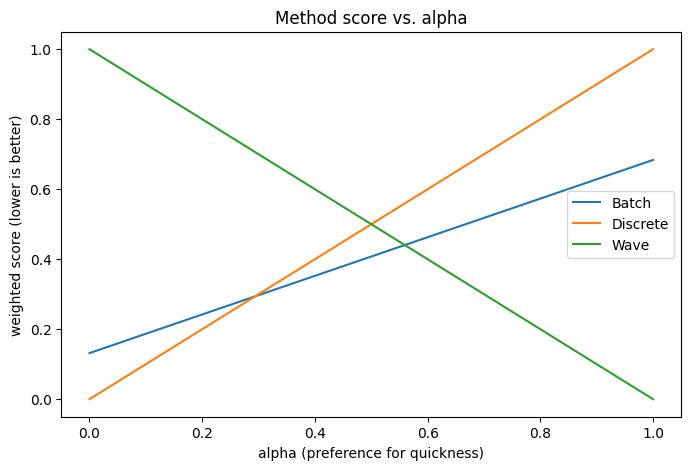

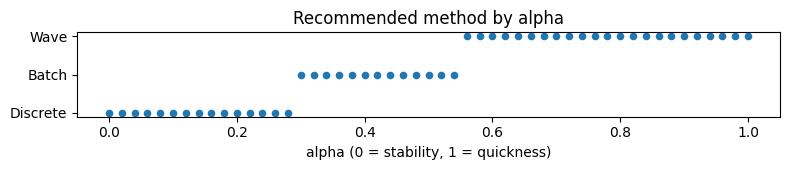

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes you already built `met` with columns:
# Method, mu, sigma, ooc, mu_n, S (from the earlier snippet)

alphas = np.linspace(0, 1, 51)
scores = {
    m: alphas*met.set_index("Method").loc[m, "mu_n"] + (1 - alphas)*met.set_index("Method").loc[m, "S"]
    for m in met["Method"]
}
scores_df = pd.DataFrame(scores, index=alphas).rename_axis("alpha").reset_index()

# which method is chosen per alpha
scores_df["Chosen"] = scores_df.drop(columns=["alpha"]).idxmin(axis=1)

display(scores_df.head())

# plot scores vs alpha
plt.figure(figsize=(8,5))
for m in met["Method"]:
    plt.plot(scores_df["alpha"], scores_df[m], label=m)
plt.xlabel("alpha (preference for quickness)")
plt.ylabel("weighted score (lower is better)")
plt.title("Method score vs. alpha")
plt.legend()
plt.show()

# plot chosen method as a function of alpha
plt.figure(figsize=(8,1.8))
plt.scatter(scores_df["alpha"], scores_df["Chosen"], s=20)
plt.yticks(met["Method"].tolist())
plt.xlabel("alpha (0 = stability, 1 = quickness)")
plt.title("Recommended method by alpha")
plt.tight_layout()
plt.show()


## 6.3 Non-Linear Recommendation Graphs

You may or may not have noticed but, the plots above assume that the trade-off between stability and speed is **linear**.  
In other words, the score is calculated as a straight weighted average:  
`score = α·mu_n + (1 − α)·S`  

This means that as α increases from 0 to 1, the importance of speed increases at a constant rate, and the resulting score for each method changes along a straight line.

But in reality, the relationship between speed and stability may not be linear.  
For example:  
- Managers may value stability much more once variation becomes too high (nonlinear penalty).  
- Improvements in speed may matter a lot at first but then give diminishing returns.  
- There could be thresholds, where any method with instability above a certain point is immediately unacceptable, no matter the speed.

If the relationship is nonlinear, the curves in the score vs alpha plot would no longer be straight lines.  
They could bend, cross, or shift more abruptly, which would change the regions where each method is recommended.  
This is why exploring nonlinear scoring functions (geometric mean, quadratic, utility with diminishing returns) can give a more realistic picture of decision-making trade-offs.  


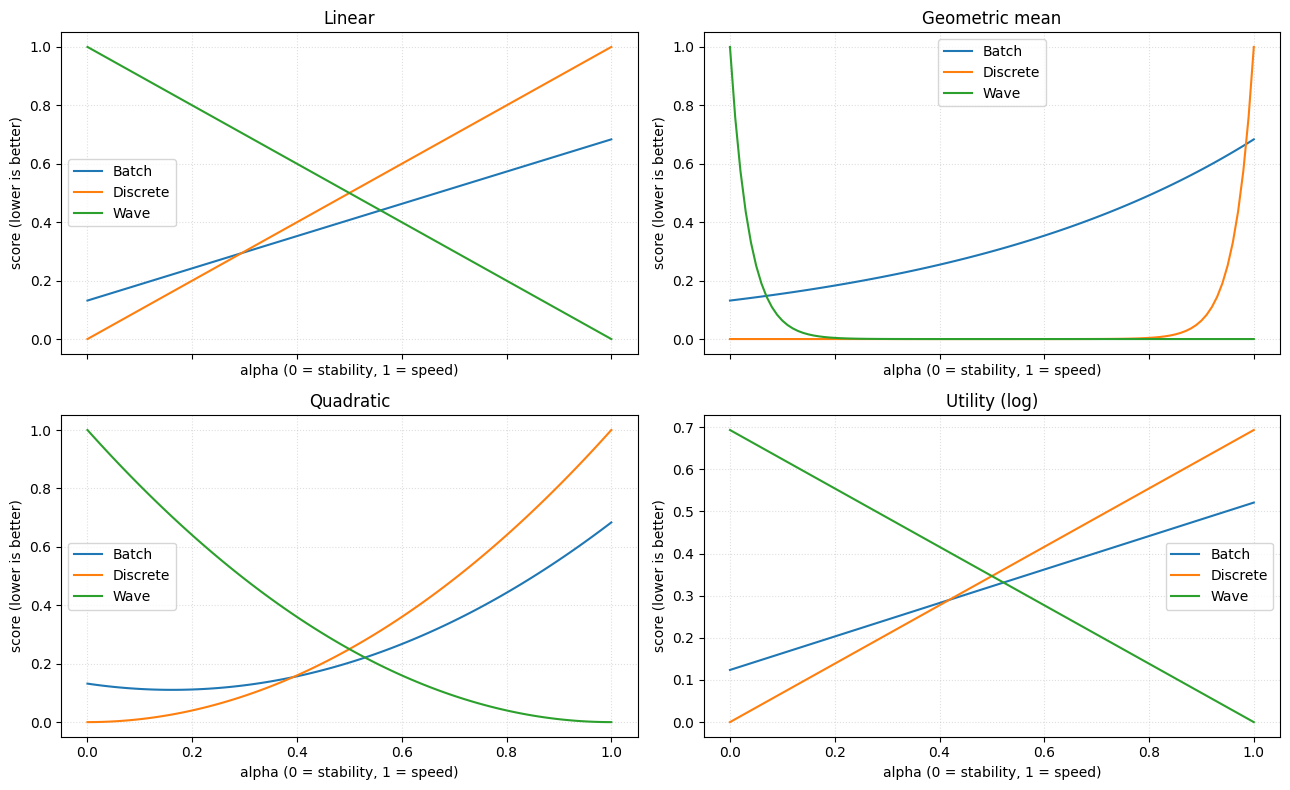

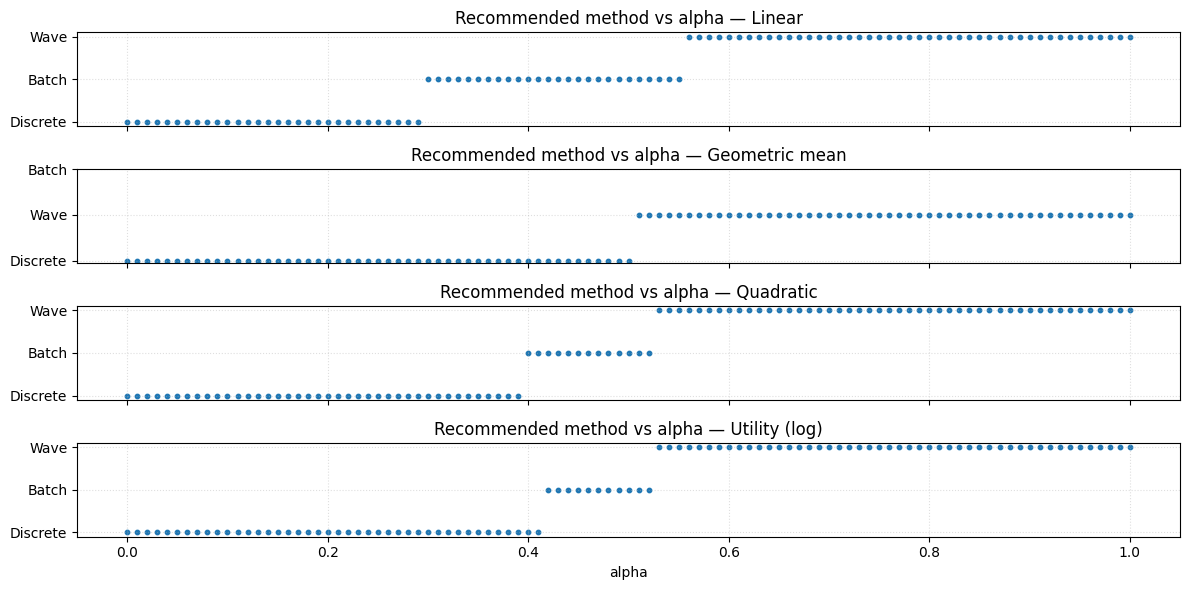

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assumes `met` with columns: Method, mu_n (0..1), S (0..1 or comparable lower-is-better)
methods = met["Method"].tolist()
mu_map = met.set_index("Method")["mu_n"].to_dict()
S_map  = met.set_index("Method")["S"].to_dict()

alphas = np.linspace(0, 1, 101)
eps = 1e-12  # for safe logs/powers

def scores_linear(alpha):
    return {m: alpha*mu_map[m] + (1-alpha)*S_map[m] for m in methods}

def scores_geometric(alpha):
    mu = {m: max(mu_map[m], eps) for m in methods}
    Ss = {m: max(S_map[m],  eps) for m in methods}
    return {m: (mu[m]**alpha)*(Ss[m]**(1-alpha)) for m in methods}

def scores_quadratic(alpha):
    return {m: (alpha**2)*mu_map[m] + ((1-alpha)**2)*S_map[m] for m in methods}

def scores_utility(alpha):
    # diminishing returns via log(1+x)
    return {m: alpha*np.log1p(mu_map[m]) + (1-alpha)*np.log1p(S_map[m]) for m in methods}

# Evaluate all alphas
def eval_scheme(fn):
    rows = []
    for a in alphas:
        sc = fn(a)
        sc["alpha"] = a
        rows.append(sc)
    df = pd.DataFrame(rows)
    cols = ["alpha"] + methods
    df = df[cols]
    df["Chosen"] = df[methods].idxmin(axis=1)
    return df

lin_df  = eval_scheme(scores_linear)
geo_df  = eval_scheme(scores_geometric)
quad_df = eval_scheme(scores_quadratic)
util_df = eval_scheme(scores_utility)

# ---- Plot scores vs alpha (four panels) ----
fig, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=True)
axes = axes.ravel()
schemes = [("Linear", lin_df), ("Geometric mean", geo_df), ("Quadratic", quad_df), ("Utility (log)", util_df)]

for ax, (title, df) in zip(axes, schemes):
    for m in methods:
        ax.plot(df["alpha"], df[m], label=m)
    ax.set_title(title)
    ax.set_xlabel("alpha (0 = stability, 1 = speed)")
    ax.set_ylabel("score (lower is better)")
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.legend()

plt.tight_layout()
plt.show()

# ---- Plot recommendation bands vs alpha (one compact chart per scheme) ----
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
for ax, (title, df) in zip(axes, schemes):
    ax.scatter(df["alpha"], df["Chosen"], s=10)
    ax.set_yticks(methods)
    ax.set_title(f"Recommended method vs alpha — {title}")
    ax.grid(True, linestyle=":", alpha=0.4)

axes[-1].set_xlabel("alpha")
plt.tight_layout()
plt.show()


> I encourage you to change the parameters for our picking methods to see the effects on our recommendation graphs.

## 6.4 Choosing the Right Trade-off Graph

To decide whether to model speed vs stability as linear or nonlinear, ask managers the following:

1. **Thresholds:**  
   Is there a minimum stability level that must be met no matter how fast the method is?  
   - If yes → use a nonlinear or threshold model.  

2. **Tolerance for Instability:**  
   Would you accept a small increase in instability for a big gain in speed?  
   - If yes → a linear model may be reasonable.  
   - If no → use a geometric mean or quadratic penalty on instability.  

3. **Diminishing Returns:**  
   Does each improvement in speed matter equally, or do early improvements matter more than later ones?  
   - If diminishing → use a utility (log) function.  

4. **Managerial Style:**  
   Do decision makers prefer a simple “balanced average” approach, or do they react strongly when one factor dominates?  
   - Balanced → linear.  
   - Strong reactions → quadratic or nonlinear.  

5. **Impact on Operations:**  
   Do past data show that instability has a disproportionate effect on cost, errors, or customer satisfaction?  
   - If yes → favor nonlinear models that penalize instability more heavily.  

Answering these questions helps determine whether to use linear weights, geometric mean, quadratic, or a utility function for the score vs alpha graph.


# 7. Summary of Analysis

We applied several statistical and operations tools to evaluate warehouse picking methods, moving from testing differences to making a final recommendation.

- ANOVA  
  Tested whether average picking times differ across methods.  
  Importance: establishes if the choice of picking method has a statistically significant impact on speed.  

- Tukey HSD Post-hoc Test  
  Identified which specific pairs of methods are significantly different.  
  Importance: shows where meaningful differences exist (for example, whether Wave is faster than Batch or Discrete).  

- SPC Charts (Individuals)  
  Tracked each method over time to check for process stability.  
  Importance: highlights whether methods are consistent or prone to instability and out-of-control variation.  

- Recommendation Charts (score vs alpha)  
  Combined quickness and stability into a single score, allowing users to specify their priorities with alpha.  
  Importance: translates statistical findings into actionable decisions, showing which method is best under different preferences for speed versus stability.  

Together, these steps provide a concrete analysis:  
ANOVA and Tukey confirm that methods differ in speed, SPC reveals which ones are stable, and the recommendation framework balances these dimensions to guide decision makers toward the method that best fits their operational priorities.
